# <br/>


# Random Search with MLflow


# <br/>

Presented par **Robin Allesiardo** de **PJD/CT_Foxtrot** (rallesiardo_at_solocal.com)

during the **Solocal AI Community of Practice (SEP 10, 2019)**
![solocal](ressources/foot_solocal.png)

jupyter nbconvert "random_search.ipynb" --to slides

In [1]:
from IPython.display import HTML
HTML('''<style>.CodeMirror{min-width:100% !important;}</style>''')

# What we will see

* Mathematics around model selection
* Why random-search is better than grid-search
* How to implement a random-search
* How to use MLflow to log results of a random-search

# Risk Minimization

Setting:
* Two space of objects $X$ and $Y$
* $\pi \in \Pi$ such as $\pi : X \rightarrow Y$
* Non-negative real-valued loss function $L(\hat{y},y)$

Goals:
* Minimizing $R(\pi)$ = ${\bf E}$ $\left[ L(\pi(x),y) \right]$
* Finding $\pi^*$ = $\arg$ $\min_{\pi \in \Pi}$ $R(\pi)$


# Bias-Variance Tradeoff
* $\Pi_m$ is the space off all the models built with hyperparameters $m$
* $\pi_{m,t}$ is the model obtained after training the model $\pi_{m,0}$ with hyperparameters $m$
* $\pi_m^* = \arg \min_{\pi \in \Pi_m} R(\pi)$

<img src="ressources/tradeoff.png" alt="tradeoff" width="500"/>


# Empirical Risk Minimization

Empirical Risk :
$$R_\text{emp}(\pi) = \frac{\sum^n_{i = 1} L(\pi(x_i),y_i) }{n} \text{.}$$

**McDiarmid inequalitie** for any $\epsilon > 0$ : 
$$ P( |R_\text{emp}(\pi) - R(\pi)| \geq \epsilon) \leq \text{exp}\left( \frac{2\epsilon^2}{\sum^n_{i=1} c^2} \right)\text{,}$$
where $c > | L(\pi(x_i),y_i) - L(\pi(x_j),y_j) |$

# Parameters Search

<img src="ressources/randomsearch.png" alt="randomsearch" width="500"/>

From Random search for hyper-parameter optimization by James Bergstra and Yoshua Bengio, JMLR vol 13, 2019

# A Classification Problem

In [2]:
import sklearn
from sklearn import datasets
digits = datasets.load_digits()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size= 0.5, shuffle = True, random_state = 0)

In [3]:
from sklearn import linear_model

param = {
"max_iter" : 1000,
"tol" : 1e-3,
}
# Définition du modèle
sgd = linear_model.SGDClassifier(**param)

# Optimisation des paramètres du modèle
sgd = sgd.fit(x_train, y_train)

sklearn.metrics.accuracy_score(sgd.predict(x_test), y_test)

0.9410456062291435

# Random Search

In [4]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

best_model = None
max_accuracy = 0

for i in tqdm(range(100)):
    
    param = {"max_iter" : np.random.randint(2000,100000),\
             "penalty" : np.random.choice(["none", "l2", "l1", "elasticnet"]),\
             "alpha": np.random.uniform(0.00001,0.001),\
             "tol" : np.random.uniform(0,1e-3)}
    
    sgd = linear_model.SGDClassifier(**param)
    sgd = sgd.fit(x_train, y_train)
    
    accuracy_test = sklearn.metrics.accuracy_score(y_test, sgd.predict(x_test))
    
    if accuracy_test > max_accuracy:
        max_accuracy = accuracy_test
        best_model = sgd
        
max_accuracy

0.9555061179087876

# Minimal MLflow logging

```python
import mlflow

mlflow.set_experiment("Experiment")

    with mlflow.start_run():
        
        ...
        
        mlflow.log_param("param", param_value)
        
        for i, ...
        
            #Do Stuff
            ...

            mlflow.log_metric("metric", metric_value, i)
            
        artifact_path = mlflow.get_artifact_uri()

```
Then start the tracking server with `mlflow ui -p $port`

<img src="ressources/mlflow1.png" alt="mlflow1" width="2500"/>

<img src="ressources/mlflow2.png" alt="mlflow2" width="2500"/>

In [5]:
import mlflow, json, os
mlflow.set_experiment("Digits")

for i in tqdm(range(100)):
    
    with mlflow.start_run():

        param = {"max_iter" : np.random.randint(2000,100000),
                 "penalty" : np.random.choice(["none", "l2", "l1", "elasticnet"]),
                 "alpha": np.random.uniform(0.00001,0.001),
                 "tol" : np.random.uniform(0,1e-3)}

        for i_key, i_value in param.items():
            mlflow.log_param(i_key, i_value)

        sgd = linear_model.SGDClassifier(**param)
        sgd = sgd.fit(x_train, y_train)

        mlflow.log_metric("acc_train",\
                          sklearn.metrics.accuracy_score(y_train, sgd.predict(x_train)))
        mlflow.log_metric("acc_test",\
                          sklearn.metrics.accuracy_score(y_test, sgd.predict(x_test)))

        artifact_path = mlflow.get_artifact_uri()
        artifact_path = artifact_path.replace("%20", " ").replace("file://", "")
        
        from joblib import dump, load
        dump(sgd, os.path.join(artifact_path, "linear.w"))
        with open(os.path.join(artifact_path, "param.json"), 'w') as f:
            json.dump(param, f)

In [6]:
df = mlflow.search_runs()
df.head()

,run_id,experiment_id,status,artifact_uri,metrics.acc_train,metrics.acc_test,params.tol,params.alpha,params.penalty,params.max_iter,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,a55959a22dc849d38df5a39af67ed116,1,FINISHED,file:///Users/rallesiardo/OneDrive%20-%20Pages...,0.985523,0.946607,0.0007339435714911382,0.0008538356754106561,none,21146,rallesiardo,LOCAL,/Library/Frameworks/Python.framework/Versions/...
1,5737a49311c34b6f982af5c08684a451,1,FINISHED,file:///Users/rallesiardo/OneDrive%20-%20Pages...,0.962138,0.923248,0.0006091422884751423,0.0001344700195589645,l2,93658,rallesiardo,LOCAL,/Library/Frameworks/Python.framework/Versions/...
2,bebea13f4d204a32ac410da89fe84144,1,FINISHED,file:///Users/rallesiardo/OneDrive%20-%20Pages...,0.991091,0.938821,0.0006657589132622829,0.000892890427019747,elasticnet,93896,rallesiardo,LOCAL,/Library/Frameworks/Python.framework/Versions/...
3,cd8957bd31e648b38721c5c617a79998,1,FINISHED,file:///Users/rallesiardo/OneDrive%20-%20Pages...,0.988864,0.947720,0.0008679598060894229,0.0005883256391608072,none,83843,rallesiardo,LOCAL,/Library/Frameworks/Python.framework/Versions/...
4,615b89bdf8624d8386d557a0630a0662,1,FINISHED,file:///Users/rallesiardo/OneDrive%20-%20Pages...,0.992205,0.953281,0.0009000008393179844,0.0002502397717589587,none,48340,rallesiardo,LOCAL,/Library/Frameworks/Python.framework/Versions/...


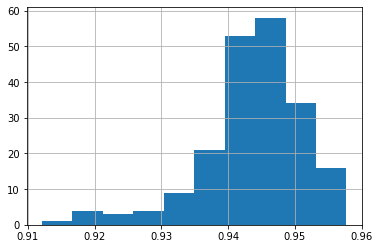

In [9]:
plot = df["metrics.acc_test"].hist().plot()

In [8]:
best_idx = df["metrics.acc_test"].idxmax()

df.iloc[best_idx]

run_id                                      25e4a00c840c4bad86d43eb91dc2dee3
experiment_id                                                              1
status                                                              FINISHED
artifact_uri               file:///Users/rallesiardo/OneDrive%20-%20Pages...
metrics.acc_train                                                   0.991091
metrics.acc_test                                                    0.957731
params.tol                                             0.0007230895043225555
params.alpha                                           0.0004112291559069391
params.penalty                                                            l1
params.max_iter                                                        83810
tags.mlflow.user                                                 rallesiardo
tags.mlflow.source.type                                                LOCAL
tags.mlflow.source.name    /Library/Frameworks/Python.framework/Versions/...

## Don't train on your test!
* Don't forget that the Random Search is somewhat part of your training
* Test your final model with data not used during the random search